In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
steam_games = pd.read_csv('../data/raw/steam.csv')
steam_games.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


In [3]:
steam_reviews = pd.read_csv('../data/raw/steam-200k.csv', header=None)
steam_reviews.head()

,0,1,2,3,4
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [4]:
steam_reviews.columns

Index([0, 1, 2, 3, 4], dtype='int64')

In [5]:
steam_reviews.drop([4], inplace=True, axis=1)

In [6]:
steam_reviews.columns = ['user_id', 'name', 'activity', 'hours_played']

In [7]:
steam_reviews.head()

,user_id,name,activity,hours_played
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [8]:
steam_games[steam_games['name'].duplicated(keep=False)].sort_values("name")

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
26587,1026330,2048,2019-02-21,1,Dexion Games,Dexion Games,windows,0,Single-player,Casual;Indie;Simulation,Indie;Casual;Simulation,0,0,1,0,0,0-20000,0.79
24723,942050,2048,2018-10-31,1,Lucas Alexander Visual Arts;Nicolai Clemmensen...,Lucas Alexander Visual Arts,windows;linux,0,Single-player;Steam Achievements;Partial Contr...,Casual;Indie;Strategy,Casual;Strategy;Indie,15,4,0,0,0,0-20000,4.49
22740,871870,Alone,2018-06-21,1,Avasion,Avasion,windows,0,Single-player;Steam Achievements;Partial Contr...,Adventure;Casual;Indie,Adventure;Indie;Casual,7,17,5,0,0,0-20000,0.79
21554,837930,Alone,2018-05-01,1,Killed Pixel Games,Killed Pixel Games,windows,0,Single-player;Steam Achievements,Adventure;Indie;Simulation;Strategy,Strategy;Adventure;Indie,20,9,2,0,0,0-20000,0.79
968,63110,Alter Ego,2010-08-03,1,bitComposer Games,Viva Media,windows,0,Single-player,Adventure,Adventure;Point & Click;Mystery,0,139,59,12,12,20000-50000,7.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16742,696580,The Tower,2018-02-16,1,Headroom.one,Headroom.one,windows,0,Single-player;Stats,Adventure;Indie,Adventure;Indie;VR,0,7,5,0,0,0-20000,5.19
6189,385240,Ultimate Arena,2016-08-22,1,Triverske,Triverske,windows,0,Single-player;Steam Achievements;Steam Trading...,Simulation,Simulation;Memes;Funny,20,715,159,280,299,50000-100000,3.99
7912,436260,Ultimate Arena,2016-09-05,1,Kenneth Caselli;Gianmarco Rocco,AceGamer Network,windows;linux,0,Multi-player;Online Multi-Player;Steam Achieve...,Action;Indie,Action;Indie;FPS,1,123,100,0,0,0-20000,13.99
13222,589160,Zombie Apocalypse,2017-02-15,1,GameTop.com,GameTop.com,windows,0,Single-player,Action,Action;Zombies;Multiplayer,0,27,17,10,10,0-20000,0.00


In [9]:
steam_games.isna().sum()

appid                0
name                 0
release_date         0
english              0
developer            1
publisher           14
platforms            0
required_age         0
categories           0
genres               0
steamspy_tags        0
achievements         0
positive_ratings     0
negative_ratings     0
average_playtime     0
median_playtime      0
owners               0
price                0
dtype: int64

In [10]:
steam_games_clean = steam_games.drop_duplicates(['name'], keep='first').dropna()

In [11]:
steam_reviews.isna().sum()

user_id         0
name            0
activity        0
hours_played    0
dtype: int64

In [12]:
steam_games_clean['name'].nunique()

27019

## Join User data and Game data

Outer join is useful to know all uses that don't have any games purchased / played and games that have no purchases / playtime

Currently I don't think we have use for users without purchases / playtime, but probably for games with 0 users (could be recommended because of similar tags / features)

In [13]:
user_games_data_full = steam_reviews.merge(steam_games_clean, on='name', how='outer')

In [14]:
user_games_data_full

,user_id,name,activity,hours_played,appid,release_date,english,developer,publisher,platforms,...,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,NaN,Fieldrunners 2,NaN,NaN,215710.0,2013-01-10,1.0,Subatomic Studios LLC,Subatomic Studios LLC,windows,...,Single-player,Action;Strategy;Casual,Tower Defense;Strategy;Casual,59.0,268.0,53.0,0.0,0.0,100000-200000,6.99
1,NaN,! That Bastard Is Trying To Steal Our Gold !,NaN,NaN,449940.0,2016-03-03,1.0,WTFOMGames,WTFOMGames,windows;linux,...,Single-player;Steam Trading Cards;Partial Cont...,Action;Adventure;Casual;Indie,Indie;Action;Adventure,0.0,17.0,46.0,396.0,410.0,100000-200000,2.89
2,NaN,!AnyWay!,NaN,NaN,866510.0,2018-06-06,1.0,GQG DEVELOPER;SGS,GQG PUBLISHER,windows,...,Single-player;Steam Achievements;Steam Trading...,Adventure;Indie,Adventure;Indie;Casual,4997.0,46.0,22.0,213.0,213.0,50000-100000,1.69
3,NaN,!LABrpgUP!,NaN,NaN,870990.0,2018-06-13,1.0,UPandQ,UPandQ,windows,...,Single-player,Adventure;Casual;Indie;RPG,Adventure;Indie;Casual,2021.0,11.0,8.0,0.0,0.0,0-20000,0.79
4,NaN,"""BUTTS: The VR Experience""",NaN,NaN,439260.0,2016-02-03,1.0,Tyler Hurd,Tyler Hurd,windows,...,Single-player;VR Support,Casual,Psychological Horror;Casual;VR,0.0,45.0,13.0,0.0,0.0,0-20000,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224825,NaN,黑暗料理?!,NaN,NaN,970530.0,2018-11-27,0.0,DoubleC Games,DoubleC Games,windows,...,Single-player,Casual;Indie;Simulation;Strategy,Casual;Strategy;Indie,0.0,11.0,2.0,0.0,0.0,0-20000,1.69
224826,NaN,신기록 : A Compendium of Ghosts,NaN,NaN,853250.0,2018-06-05,0.0,Team 33,Team 33,windows,...,Single-player,Adventure;Casual;Free to Play;Indie;RPG,Adventure;Free to Play;RPG,0.0,29.0,2.0,0.0,0.0,0-20000,0.00
224827,NaN,암전:Blackout,NaN,NaN,871810.0,2019-04-23,1.0,MaruStudio,MaruStudio,windows,...,Single-player;Steam Achievements;Full controll...,Adventure;Indie,Adventure;Indie;Horror,6.0,10.0,30.0,0.0,0.0,0-20000,15.49
224828,NaN,４人打ちアクション麻雀 / ACTION MAHJONG,NaN,NaN,575810.0,2017-02-24,0.0,"Mindware Co.,Ltd.","Mindware Co.,Ltd.",windows,...,Single-player;Multi-player;Local Multi-Player;...,Action;Casual;Indie;Early Access,Early Access;Action;Indie,66.0,12.0,1.0,0.0,0.0,0-20000,6.99


In [15]:
user_games_data = steam_reviews.merge(steam_games_clean, on='name', how='inner')

In [16]:
user_games_data

,user_id,name,activity,hours_played,appid,release_date,english,developer,publisher,platforms,...,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,151603712,Fallout 4,purchase,1.0,377160,2015-11-09,1,Bethesda Game Studios,Bethesda Softworks,windows,...,Single-player;Steam Achievements;Full controll...,RPG,Open World;Post-apocalyptic;Exploration,84,110376,45377,4822,2904,5000000-10000000,19.99
1,151603712,Fallout 4,play,87.0,377160,2015-11-09,1,Bethesda Game Studios,Bethesda Softworks,windows,...,Single-player;Steam Achievements;Full controll...,RPG,Open World;Post-apocalyptic;Exploration,84,110376,45377,4822,2904,5000000-10000000,19.99
2,151603712,Left 4 Dead 2,purchase,1.0,550,2009-11-19,1,Valve,Valve,windows;mac;linux,...,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Zombies;Co-op;FPS,70,251789,8418,1615,566,10000000-20000000,7.19
3,151603712,Left 4 Dead 2,play,8.9,550,2009-11-19,1,Valve,Valve,windows;mac;linux,...,Single-player;Multi-player;Co-op;Steam Achieve...,Action,Zombies;Co-op;FPS,70,251789,8418,1615,566,10000000-20000000,7.19
4,151603712,HuniePop,purchase,1.0,339800,2015-01-19,1,HuniePot,HuniePot,windows;mac;linux,...,Single-player;Steam Achievements;Steam Trading...,Indie;RPG;Simulation;Strategy,Nudity;Mature;Anime,20,17761,711,2741,780,500000-1000000,6.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92808,128470551,Magic Duels,play,2.2,316010,2015-07-29,1,Stainless Games Ltd.,Wizards of the Coast LLC,windows,...,Single-player;Multi-player;Co-op;Shared/Split ...,Free to Play;Strategy,Free to Play;Card Game;Trading Card Game,49,16599,6912,1854,125,2000000-5000000,0.00
92809,128470551,Titan Souls,purchase,1.0,297130,2015-04-14,1,Acid Nerve,Devolver Digital,windows;mac,...,Single-player;Steam Achievements;Full controll...,Action;Adventure;Indie,Pixel Graphics;Difficult;Adventure,27,3556,981,46,67,200000-500000,10.99
92810,128470551,Titan Souls,play,1.5,297130,2015-04-14,1,Acid Nerve,Devolver Digital,windows;mac,...,Single-player;Steam Achievements;Full controll...,Action;Adventure;Indie,Pixel Graphics;Difficult;Adventure,27,3556,981,46,67,200000-500000,10.99
92811,128470551,RUSH,purchase,1.0,38720,2010-12-03,1,Two Tribes,Two Tribes Publishing,windows;mac;linux,...,Single-player;Steam Achievements;Steam Cloud,Casual;Indie;Strategy,Puzzle;Indie;Casual,25,1069,117,53,56,200000-500000,3.99


In [17]:
user_games_data.isna().sum()

user_id             0
name                0
activity            0
hours_played        0
appid               0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

In [18]:
user_games_data[user_games_data['name'].duplicated(keep=False) & user_games_data['activity'] == 'play']

,user_id,name,activity,hours_played,appid,release_date,english,developer,publisher,platforms,...,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price


In [19]:
user_games_data[user_games_data['name'].duplicated(keep=False) & user_games_data['activity'] == 'purchase']

,user_id,name,activity,hours_played,appid,release_date,english,developer,publisher,platforms,...,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price


In [20]:
unique_games = user_games_data['appid'].nunique()
unique_users = user_games_data['user_id'].nunique()
unique_games, unique_users

(2189, 10121)

In [21]:
user_games_data.to_csv('../data/preprocessed/user_games_data.csv', index=False)

In [22]:
user_activity = user_games_data[user_games_data['activity'] == 'purchase'][['user_id', 'activity']].groupby(['user_id']).count()
user_activity.sort_values(by='activity', ascending=False)

,activity
user_id,
62990992,459
33865373,354
30246419,339
11403772,274
58345543,273
...,...
307879703,1
308851352,1
158469748,1


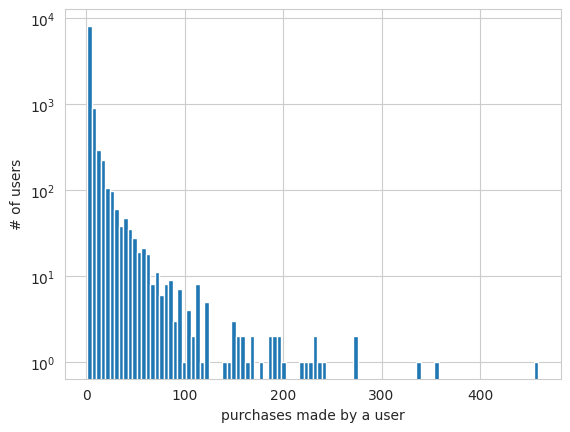

In [23]:
plt.yscale('log')
plt.hist(user_activity.activity, bins=100)
plt.xlabel('purchases made by a user')
plt.ylabel('# of users')
plt.show()

In [24]:
activity_by_game = user_games_data[user_games_data['activity'] == 'play'][['appid', 'name', 'activity', 'hours_played']].groupby(['appid', 'name']).agg({'activity': 'count', 'hours_played': 'mean'}).reset_index().rename(columns={'activity': 'activity', 'hours_played': 'avg_hours_played'})
activity_by_game.sort_values(by='activity', ascending=False)

,appid,name,activity,avg_hours_played
11,570,Dota 2,4841,202.785499
8,440,Team Fortress 2,2323,74.762505
1204,304930,Unturned,1069,15.057437
10,550,Left 4 Dead 2,801,41.943446
50,4000,Garry's Mod,666,74.662613
...,...,...,...,...
1273,314010,Boid,1,8.900000
1280,314290,Obludia,1,3.000000
1281,314320,GamersGoMakers,1,26.000000
1283,314470,Heroes of a Broken Land,1,0.500000


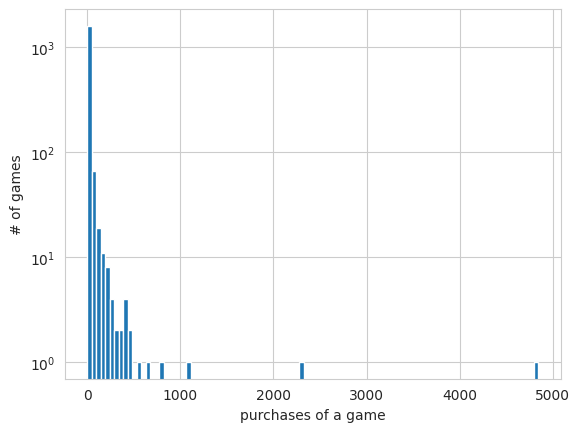

In [25]:
plt.yscale('log')
plt.hist(activity_by_game.activity, bins=100)
plt.xlabel('purchases of a game')
plt.ylabel('# of games')
plt.show()

In [26]:
top_10 = activity_by_game.sort_values(by='activity', ascending=False).head(10).reset_index()

In [27]:
top_10_games = steam_games.merge(top_10, on=['appid', 'name'], how='inner').sort_values(by='activity', ascending=False)
top_10_games

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,...,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,index,activity,avg_hours_played
4,570,Dota 2,2013-07-09,1,Valve,Valve,windows;mac;linux,0,Multi-player;Co-op;Steam Trading Cards;Steam W...,Action;Free to Play;Strategy,...,0,863507,142079,23944,801,100000000-200000000,0.00,11,4841,202.785499
2,440,Team Fortress 2,2007-10-10,1,Valve,Valve,windows;mac;linux,0,Multi-player;Cross-Platform Multiplayer;Steam ...,Action;Free to Play,...,520,515879,34036,8495,623,20000000-50000000,0.00,8,2323,74.762505
9,304930,Unturned,2017-07-07,1,Smartly Dressed Games,Smartly Dressed Games,windows;mac;linux,0,Single-player;Online Multi-Player;Online Co-op...,Action;Adventure;Casual;Free to Play;Indie,...,46,292574,31482,3248,413,20000000-50000000,0.00,1204,1069,15.057437
3,550,Left 4 Dead 2,2009-11-19,1,Valve,Valve,windows;mac;linux,0,Single-player;Multi-player;Co-op;Steam Achieve...,Action,...,70,251789,8418,1615,566,10000000-20000000,7.19,10,801,41.943446
6,4000,Garry's Mod,2006-11-29,1,Facepunch Studios,Valve,windows;mac;linux,0,Single-player;Multi-player;Co-op;Cross-Platfor...,Indie;Simulation,...,29,363721,16433,12422,1875,10000000-20000000,6.99,50,666,74.662613
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,...,0,124534,3339,17612,317,10000000-20000000,7.19,0,568,236.375176
7,105600,Terraria,2011-05-16,1,Re-Logic,Re-Logic,windows;mac;linux,0,Single-player;Multi-player;Online Multi-Player...,Action;Adventure;Indie;RPG,...,88,255600,7797,5585,1840,5000000-10000000,6.99,360,460,65.112609
5,620,Portal 2,2011-04-18,1,Valve,Valve,windows;mac;linux,0,Single-player;Co-op;Steam Achievements;Full co...,Action;Adventure,...,51,138220,1891,1102,520,10000000-20000000,7.19,12,453,20.126049
8,230410,Warframe,2013-03-25,1,Digital Extremes,Digital Extremes,windows,16,Single-player;Multi-player;Co-op;Steam Trading...,Action;Free to Play,...,187,226541,20268,5845,394,20000000-50000000,0.00,611,424,63.855189
1,400,Portal,2007-10-10,1,Valve,Valve,windows;mac;linux,0,Single-player;Steam Achievements;Captions avai...,Action,...,15,51801,1080,288,137,10000000-20000000,7.19,7,417,5.474341


In [28]:
supported_platforms = steam_games['platforms'].str.get_dummies(sep=';')
supported_platforms

,linux,mac,windows
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
27070,0,0,1
27071,0,0,1
27072,0,0,1
27073,0,1,1


In [29]:
supported_platforms.sum()

linux       5235
mac         8066
windows    27070
dtype: int64

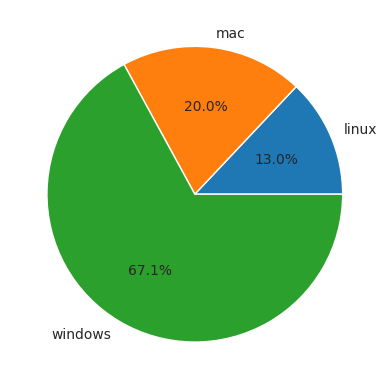

In [30]:
plt.pie(supported_platforms.sum(), labels=['linux', 'mac', 'windows'], autopct='%1.1f%%')
plt.show()

In [31]:
played_games = user_games_data[['name', 'genres', 'categories']].drop_duplicates(['name'], keep='first').dropna()
played_games

,name,genres,categories
0,Fallout 4,RPG,Single-player;Steam Achievements;Full controll...
2,Left 4 Dead 2,Action,Single-player;Multi-player;Co-op;Steam Achieve...
4,HuniePop,Indie;RPG;Simulation;Strategy,Single-player;Steam Achievements;Steam Trading...
6,Path of Exile,Action;Adventure;Free to Play;Indie;Massively ...,Single-player;Multi-player;Online Multi-Player...
8,Poly Bridge,Indie;Simulation,Single-player;Steam Achievements;Steam Trading...
...,...,...,...
92139,SAMURAI WARRIORS 4-II,Action,Single-player;Multi-player;Co-op;Steam Achieve...
92171,The Bug Butcher,Action;Indie,Single-player;Local Co-op;Shared/Split Screen;...
92210,Warriors & Castles,Action;Indie;Early Access,Multi-player;Online Multi-Player;Cross-Platfor...
92645,Life is Hard,Adventure;Indie;Simulation;Strategy;Early Access,Single-player;Steam Achievements;Steam Trading...


In [32]:
dummies_genres = played_games['genres'].str.get_dummies(sep=";").add_prefix('')
dummies_genres.columns = dummies_genres.columns.str.upper().str.replace(' ', '_')
dummies_genres

,ACTION,ADVENTURE,ANIMATION_&_MODELING,CASUAL,DESIGN_&_ILLUSTRATION,EARLY_ACCESS,EDUCATION,FREE_TO_PLAY,GAME_DEVELOPMENT,GORE,...,RACING,SEXUAL_CONTENT,SIMULATION,SOFTWARE_TRAINING,SPORTS,STRATEGY,UTILITIES,VIDEO_PRODUCTION,VIOLENT,WEB_PUBLISHING
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
6,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92139,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92171,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92210,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92645,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [33]:
genres = dummies_genres.sum().to_frame().reset_index().rename(columns={0: 'count'})
genres['percentage'] = genres['count'] / genres['count'].sum() * 100
genres['category'] = genres.apply(lambda x: 'OTHERS' if x['percentage'] < 2 else x['index'], axis=1)
genres.sort_values(by='count', ascending=False)

,index,count,percentage,category
10,INDIE,1430,25.830925,INDIE
0,ACTION,1015,18.334538,ACTION
1,ADVENTURE,693,12.518064,ADVENTURE
20,STRATEGY,542,9.790462,STRATEGY
3,CASUAL,490,8.851156,CASUAL
14,RPG,432,7.803468,RPG
17,SIMULATION,359,6.484827,SIMULATION
7,FREE_TO_PLAY,193,3.486272,FREE_TO_PLAY
15,RACING,86,1.553468,OTHERS
11,MASSIVELY_MULTIPLAYER,84,1.517341,OTHERS


In [34]:
pie_genres = genres.groupby('category')['count'].sum()
pie_genres = pie_genres.sort_values(ascending=False)

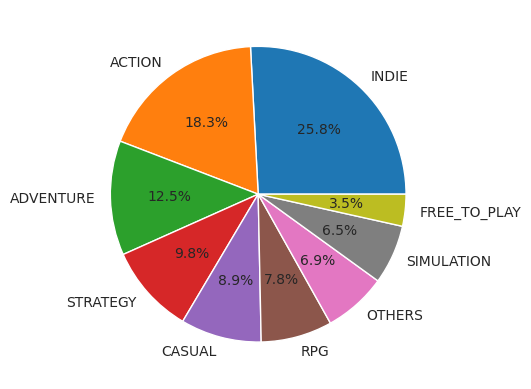

In [35]:
plt.pie(pie_genres, labels=pie_genres.index, autopct='%1.1f%%')
plt.show()

In [36]:
dummies_categories = played_games['categories'].str.get_dummies(sep=";").add_prefix('')
dummies_categories.columns = dummies_categories.columns.str.upper().str.replace(' ', '_')
dummies_categories

,CAPTIONS_AVAILABLE,CO-OP,COMMENTARY_AVAILABLE,CROSS-PLATFORM_MULTIPLAYER,FULL_CONTROLLER_SUPPORT,IN-APP_PURCHASES,INCLUDES_SOURCE_SDK,INCLUDES_LEVEL_EDITOR,LOCAL_CO-OP,LOCAL_MULTI-PLAYER,...,STATS,STEAM_ACHIEVEMENTS,STEAM_CLOUD,STEAM_LEADERBOARDS,STEAM_TRADING_CARDS,STEAM_TURN_NOTIFICATIONS,STEAM_WORKSHOP,STEAMVR_COLLECTIBLES,VR_SUPPORT,VALVE_ANTI-CHEAT_ENABLED
0,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,1,1,1,0,1,0,1,0,0,0,...,1,1,1,0,1,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
6,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92139,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
92171,0,0,0,0,1,0,0,0,1,0,...,1,1,1,1,1,0,0,0,0,0
92210,0,0,0,1,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
92645,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0


In [37]:
categories = dummies_categories.sum().to_frame().reset_index().rename(columns={0: 'count'})
categories['percentage'] = categories['count'] / categories['count'].sum() * 100
categories['category'] = categories.apply(lambda x: 'OTHERS' if x['percentage'] < 2 else x['index'], axis=1)
categories.sort_values(by='count', ascending=False)

,index,count,percentage,category
16,SINGLE-PLAYER,2047,22.469813,SINGLE-PLAYER
18,STEAM_ACHIEVEMENTS,1297,14.237102,STEAM_ACHIEVEMENTS
21,STEAM_TRADING_CARDS,1144,12.557629,STEAM_TRADING_CARDS
19,STEAM_CLOUD,805,8.836443,STEAM_CLOUD
11,MULTI-PLAYER,602,6.608123,MULTI-PLAYER
4,FULL_CONTROLLER_SUPPORT,542,5.949506,FULL_CONTROLLER_SUPPORT
14,PARTIAL_CONTROLLER_SUPPORT,459,5.038419,PARTIAL_CONTROLLER_SUPPORT
20,STEAM_LEADERBOARDS,443,4.862788,STEAM_LEADERBOARDS
1,CO-OP,267,2.930845,CO-OP
17,STATS,208,2.283205,STATS


In [38]:
pie_categories = categories.groupby('category')['count'].sum()
pie_categories = pie_categories.sort_values(ascending=False)

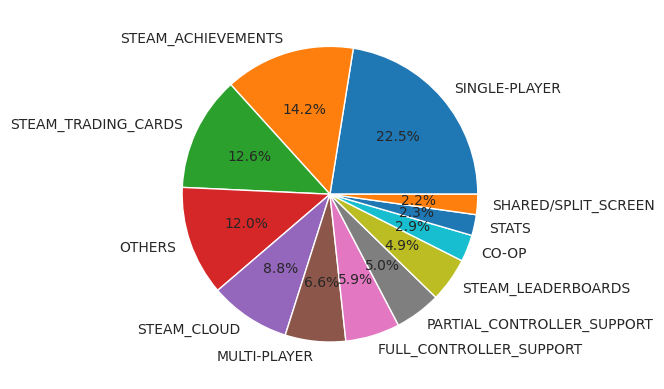

In [39]:
plt.pie(pie_categories, labels=pie_categories.index, autopct='%1.1f%%')
plt.show()

### Correlation between variables

In [40]:
activity_by_game.sort_values(by=['activity', 'avg_hours_played'], ascending=False)

,appid,name,activity,avg_hours_played
11,570,Dota 2,4841,202.785499
8,440,Team Fortress 2,2323,74.762505
1204,304930,Unturned,1069,15.057437
10,550,Left 4 Dead 2,801,41.943446
50,4000,Garry's Mod,666,74.662613
...,...,...,...,...
1510,350620,Sandmason,1,0.100000
1601,368650,Dark Echo,1,0.100000
1632,381560,Epic Cards Battle(TCG),1,0.100000
1678,398000,Little Big Adventure 2,1,0.100000


In [41]:
expanded_activity = activity_by_game.merge(steam_games, on=['name', 'appid'], how='inner')
expanded_activity

,appid,name,activity,avg_hours_played,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,568,236.375176,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,26,0.873077,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,94,14.377660,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,32,0.740625,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,60,Ricochet,21,1.009524,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Valve Anti-Ch...,Action,Action;FPS;Multiplayer,0,2758,684,175,10,5000000-10000000,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,752180,One Night,1,0.400000,2018-02-16,1,Dark Gaia Studios,Dark Gaia Studios,windows,0,Single-player;Full controller support,Adventure;Indie,Adventure;Indie,0,11,1,0,0,0-20000,0.00
1715,764050,Maelstrom,1,0.500000,2018-04-11,1,"Gunpowder Games, LLC","Gunpowder Games, LLC",windows,0,Multi-player;Online Multi-Player;Partial Contr...,Action;Indie;Massively Multiplayer;Simulation;...,Early Access;Action;Massively Multiplayer,0,640,107,0,0,20000-50000,15.49
1716,860270,Requiem,4,1.225000,2018-11-02,1,Netlex Studio,Netlex Studio,windows,0,Multi-player;Online Multi-Player,Action;Massively Multiplayer;RPG;Early Access,Early Access;Action;RPG,0,1,1,0,0,0-20000,3.99
1717,890400,Uncharted Waters Online,1,181.000000,2018-12-19,1,"KOEI TECMO GAMES CO., LTD.",Papaya Play,windows,0,Online Multi-Player;MMO;Online Co-op;In-App Pu...,Adventure;Free to Play;Massively Multiplayer;R...,Massively Multiplayer;RPG;Free to Play,0,71,44,0,0,20000-50000,0.00


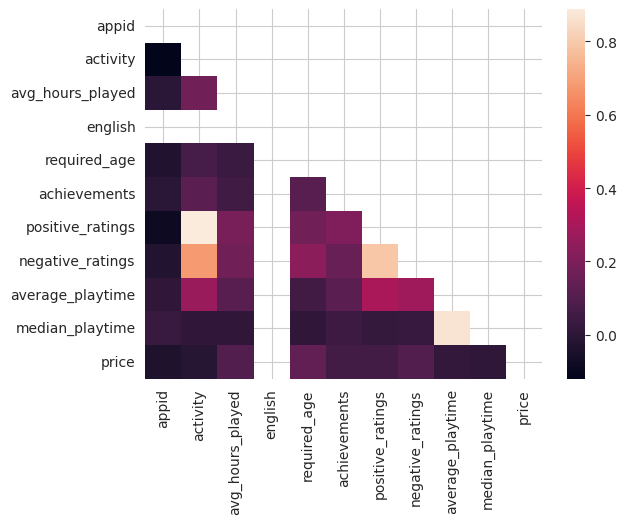

In [42]:
corr = expanded_activity.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask)
plt.show()